# setup

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append("/usr/local/Cellar/opencv3/3.2.0/lib/python3.5/site-packages/") # mac opencv path
import cv2
import numpy as np
from typing import Tuple, List, Text, Dict, Any, Iterator
import time


def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

# input data

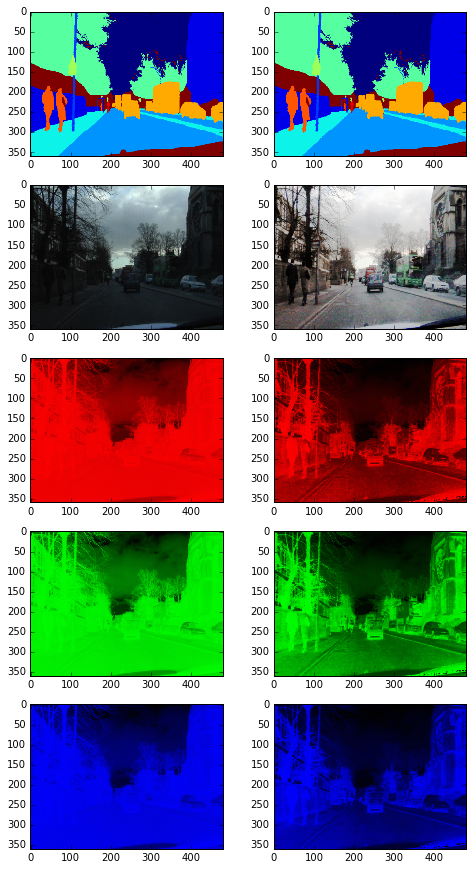

In [4]:
#x = 'SegNet-Tutorial/CamVid/test/0001TP_008550.png'
#y = 'SegNet-Tutorial/CamVid/testannot/0001TP_008550.png'
x = 'SegNet-Tutorial/CamVid/train/0001TP_007140.png'
y = 'SegNet-Tutorial/CamVid/trainannot/0001TP_007140.png'

img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
norm = np.ones(img.shape, img.dtype)*255
norm[:,:,0] = cv2.equalizeHist(img[:,:,0])
norm[:,:,1] = cv2.equalizeHist(img[:,:,1])
norm[:,:,2] = cv2.equalizeHist(img[:,:,2])

mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
annot = np.zeros(mask.shape, np.uint8)
for i in range(12): annot[np.where(mask == i)] = 255/12*i

mat1 = [
    [
        lambda x: plt.imshow(mask),
        lambda x: plt.imshow(annot),
    ],
    [
        lambda x: plt.imshow(img),
        lambda x: plt.imshow(norm),
    ]
]

for ch in range(3):
    mat1.append([
        (lambda ch:
            (lambda x: exec('tmp = np.ones(norm.shape, np.int8)*255; tmp[:,:,%d] = img[:,:,%d]; plt.imshow(tmp)' % (ch, ch)))
        )(ch),
        (lambda ch:
            (lambda x: exec('tmp = np.ones(norm.shape, np.int8)*255; tmp[:,:,%d] = norm[:,:,%d]; plt.imshow(tmp)' % (ch, ch)))
        )(ch),
    ])

mtx_plot(mat1, ratio=(4,3))


# prediction

Using TensorFlow backend.


(1, 480, 360, 12) (480, 360, 12)
(360, 480, 12)
(360, 480)
[[ 3  3  6 ...,  0  0  0]
 [ 6  6  6 ...,  6  0  7]
 [ 6  2  6 ...,  6  6  7]
 ..., 
 [ 6  6  6 ...,  6  9  0]
 [ 6  6  6 ...,  6  4  4]
 [ 0  0 10 ...,  6  4  4]]


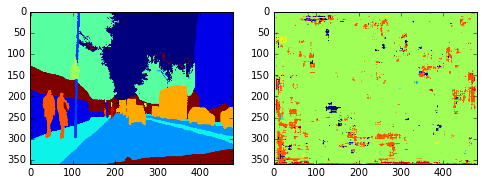

In [5]:

import tensorflow as tf

name = "segnet_2017-04-12-10-30-33"; use_indices = False
#name = "segnet_2017-04-12-10-30-51_indices"; use_indices = True

with tf.device('/cpu:0'):
    from keras.models import model_from_json
    if use_indices:
        import SegNet
        model = SegNet.create_segnet(shape=(480, 360, 3), nb_class=12, indices=True)
        model.load_weights(name + '_weight.hdf5')
    else:
        with open(name + '_model.json', 'r') as f: model = model_from_json(f.read())
        model.load_weights(name + '_weight.hdf5')
    frame = np.expand_dims(np.einsum('hwc->whc', img), axis=0)
    output = model.predict(frame)
    
    print(output.shape, output[0].shape)
    output = np.einsum('whc->hwc', output[0])
    print(output.shape)
    output = np.argmax(output, axis=2)
    print(output.shape)
    print(output)



    
_annot = np.zeros(annot.shape, np.uint8)
for i in range(12): _annot[np.where(output == i)] = 255/12*i

mat2 = [
    [
        lambda x: plt.imshow(annot),
        lambda x: plt.imshow(_annot),
    ],
]

mtx_plot(mat2, ratio=(4,3))